# Challenge 1 - Tic Tac Toe

In this lab you will perform deep learning analysis on a dataset of playing [Tic Tac Toe](https://en.wikipedia.org/wiki/Tic-tac-toe).

There are 9 grids in Tic Tac Toe that are coded as the following picture shows:

![Tic Tac Toe Grids](tttboard.jpg)

In the first 9 columns of the dataset you can find which marks (`x` or `o`) exist in the grids. If there is no mark in a certain grid, it is labeled as `b`. The last column is `class` which tells you whether Player X (who always moves first in Tic Tac Toe) wins in this configuration. Note that when `class` has the value `False`, it means either Player O wins the game or it ends up as a draw.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy

from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Follow the steps suggested below to conduct a neural network analysis using Tensorflow and Keras. You will build a deep learning model to predict whether Player X wins the game or not.

## Step 1: Data Engineering

This dataset is almost in the ready-to-use state so you do not need to worry about missing values and so on. Still, some simple data engineering is needed.

1. Read `tic-tac-toe.csv` into a dataframe.
1. Inspect the dataset. Determine if the dataset is reliable by eyeballing the data.
1. Convert the categorical values to numeric in all columns.
1. Separate the inputs and output.
1. Normalize the input data.

**Read tic-tac-toe.csv into a dataframe.**

In [3]:
ttt = pd.read_csv('/content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/tic-tac-toe.csv')
ttt

,TL,TM,TR,ML,MM,MR,BL,BM,BR,class
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,x,o,True
2,x,x,x,x,o,o,o,o,x,True
3,x,x,x,x,o,o,o,b,b,True
4,x,x,x,x,o,o,b,o,b,True
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,False
954,o,x,o,x,x,o,x,o,x,False
955,o,x,o,x,o,x,x,o,x,False
956,o,x,o,o,x,x,x,o,x,False


**Inspect the dataset. Determine if the dataset is reliable by eyeballing the data.**

In [4]:
for i in ttt.columns:
  print(ttt[i].unique())

['x' 'o' 'b']
['x' 'o' 'b']
['x' 'o' 'b']
['x' 'o' 'b']
['o' 'b' 'x']
['o' 'b' 'x']
['x' 'o' 'b']
['o' 'x' 'b']
['o' 'x' 'b']
[ True False]


In [5]:
ttt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TL      958 non-null    object
 1   TM      958 non-null    object
 2   TR      958 non-null    object
 3   ML      958 non-null    object
 4   MM      958 non-null    object
 5   MR      958 non-null    object
 6   BL      958 non-null    object
 7   BM      958 non-null    object
 8   BR      958 non-null    object
 9   class   958 non-null    bool  
dtypes: bool(1), object(9)
memory usage: 68.4+ KB


**Separate the inputs and output.**

In [6]:
y = ttt['class']
X = ttt.iloc[:,:-1]

**Convert the categorical values to numeric in all columns.**

In [7]:
encoder = OneHotEncoder(drop='first').fit(X)

X_np = encoder.transform(X).toarray()

X_encoded = pd.DataFrame(X_np, columns=encoder.get_feature_names_out())

Let's normalize and scale the data 

In [8]:
X_normalized = PowerTransformer().fit_transform(X_encoded)
X_norm = pd.DataFrame(X_normalized, columns = X_encoded.columns)

In [9]:
X_scaled = MinMaxScaler().fit_transform(X_norm)
X_transformed = pd.DataFrame(X_scaled, columns=X_encoded.columns)

In [10]:
X_transformed

,TL_o,TL_x,TM_o,TM_x,TR_o,TR_x,ML_o,ML_x,MM_o,MM_x,MR_o,MR_x,BL_o,BL_x,BM_o,BM_x,BR_o,BR_x
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
954,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
955,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
956,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


## Step 2: Build Neural Network

To build the neural network, you can refer to your own codes you wrote while following the [Deep Learning with Python, TensorFlow, and Keras tutorial](https://www.youtube.com/watch?v=wQ8BIBpya2k) in the lesson. It's pretty similar to what you will be doing in this lab.

1. Split the training and test data.
1. Create a `Sequential` model.
1. Add several layers to your model. Make sure you use ReLU as the activation function for the middle layers. Use Softmax for the output layer because each output has a single lable and all the label probabilities add up to 1.
1. Compile the model using `adam` as the optimizer and `sparse_categorical_crossentropy` as the loss function. For metrics, use `accuracy` for now.
1. Fit the training data.
1. Evaluate your neural network model with the test data.
1. Save your model as `tic-tac-toe.model`.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=23)

**Building the Neural Netwok**

In [12]:
early_stopping = EarlyStopping(patience=5)

model = keras.Sequential()
model.add(Dense(units = 16,input_dim = X_train.shape[1],activation='relu'))
model.add(Dense(units = 8,activation='relu'))
model.add(Dense(units = 2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                304       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 458
Trainable params: 458
Non-trainable params: 0
_________________________________________________________________


**Adding check point for each epoch**

In [13]:
checkpoint_path = '/content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, # Where to save the checkpoint.
    save_freq='epoch', # How often the checkpoint file will be saved.
    save_weights_only=False, # Wether or not save only the weights of each neuron.
    verbose=1 # To display the progress
)

**Fitting the training data**

In [14]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=60, # Number of epochs. 
    validation_split=0.20, # Here the TRAIN set will be split in TRAIN = TRAIN_NEW + VALIDATION. TRAIN_NEW used for train and val for CV
    batch_size=20, # How many samples to input in the network before updating the weights
    verbose=2, # To display the progress.
    callbacks=[early_stopping,checkpoint])

Epoch 1/60

Epoch 1: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 - 2s - loss: 0.6564 - accuracy: 0.6549 - val_loss: 0.6401 - val_accuracy: 0.6567 - 2s/epoch - 80ms/step
Epoch 2/60

Epoch 2: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 - 0s - loss: 0.6319 - accuracy: 0.6604 - val_loss: 0.6213 - val_accuracy: 0.6716 - 146ms/epoch - 5ms/step
Epoch 3/60

Epoch 3: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 - 0s - loss: 0.6147 - accuracy: 0.6642 - val_loss: 0.6067 - val_accuracy: 0.6716 - 155ms/epoch - 6ms/step
Epoch 4/60

Epoch 4: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 - 0s - loss: 0.5999 - accuracy: 0.6660 - val_loss: 0.5949 - val_accuracy: 0.6716 - 140ms/epoch - 5ms/step
Epoch 5/60

Epoch 5: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 - 0s - loss: 

In [15]:
def plot_metrics(history, metric, metric2):
    train_metrics = history.history[metric] # Get the error metric for the TRAIN set
    val_metrics = history.history['val_'+metric] # Get the error metric for the VALIDATION set

    train_metrics2 = history.history[metric2] # Get the error metric for the TRAIN set
    val_metrics2 = history.history['val_'+metric2] # Get the error metric for the VALIDATION set

    epochs = range(1, len(train_metrics) + 1) # range(1,6) -> 1,2,3,4,5
       
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(epochs, train_metrics)
    ax1.plot(epochs, val_metrics)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(metric)
    ax1.set_yscale('log')
    ax1.legend(["train_"+metric, 'val_'+metric])

    ax2.plot(epochs, train_metrics2)
    ax2.plot(epochs, val_metrics2)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel(metric2)
    ax2.set_yscale('log')
    ax2.legend(["train_"+metric2, 'val_'+metric2])

    plt.show()

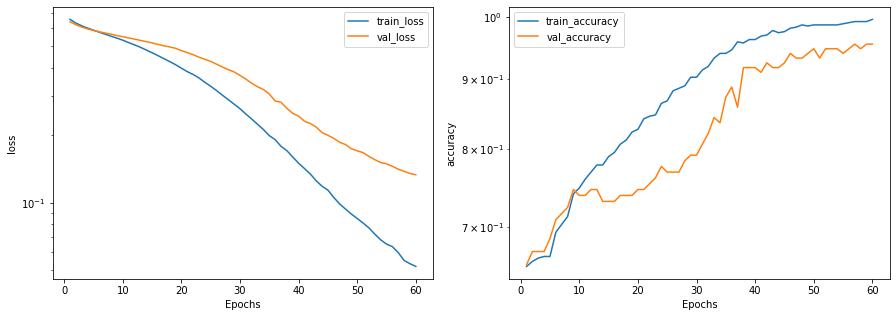

In [16]:
plot_metrics(history,'loss','accuracy')

**Evaluating the performance of the best model**

In [17]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

In [18]:
y_pred_tr = np.argmax(model.predict(X_train), axis=1).reshape(-1,1)
y_pred_te = np.argmax(model.predict(X_test), axis=1).reshape(-1,1)

model_performance_class(y_train, y_pred_tr, y_test, y_pred_te)

9/9 [==============================] - 0s 2ms/step
Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.97
              precision    recall  f1-score   support

       False       0.98      0.99      0.98       236
        True       0.99      0.99      0.99       434

    accuracy                           0.99       670
   macro avg       0.99      0.99      0.99       670
weighted avg       0.99      0.99      0.99       670

Results obtained for the TEST SET
The Cohen's Kappa is: 0.95
              precision    recall  f1-score   support

       False       0.97      0.96      0.96        96
        True       0.98      0.98      0.98       192

    accuracy                           0.98       288
   macro avg       0.97      0.97      0.97       288
weighted avg       0.98      0.98      0.98       288



**Saving the best model**

In [19]:
import pickle
with open('/content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/tic-tac-toe_model.pkl', 'wb') as file: pickle.dump(model, file)

best_model = pd.read_pickle('/content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/tic-tac-toe_model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-03-29 10:11:36           64
config.json                                    2023-03-29 10:11:36         1833
variables.h5                                   2023-03-29 10:11:36        29328
Keras model archive loading:
File Name                                             Modified         

## Step 3: Make Predictions

Now load your saved model and use it to make predictions on a few random rows in the test dataset. Check if the predictions are correct.

In [20]:
pd.DataFrame(y_train).value_counts()

class
True     434
False    236
dtype: int64

In [21]:
def check_predictions(x,y,row):
  y=list(y)[row]
  x = x.loc[row:row,:]

  prediction = np.argmax(best_model.predict(x), axis=1).reshape(-1,1)
  if prediction==1: p = True
  else: p = False

  if y == p: a='right'
  else: a='wrong'

  return print('Result is {} and prediction is {}'.format(y,a))

In [22]:
check_predictions(X_train,y_train,200)

1/1 [==============================] - 0s 68ms/step
Result is False and prediction is wrong


In [23]:
check_predictions(X_test,y_test,45)

1/1 [==============================] - 0s 25ms/step
Result is True and prediction is right


In [24]:
check_predictions(X_train,y_train,5)

1/1 [==============================] - 0s 26ms/step
Result is True and prediction is right


In [25]:
check_predictions(X_test,y_test,167)

1/1 [==============================] - 0s 25ms/step
Result is True and prediction is right


## Step 4: Improve Your Model

Did your model achieve low loss (<0.1) and high accuracy (>0.95)? If not, try to improve your model.

But how? There are so many things you can play with in Tensorflow and in the next challenge you'll learn about these things. But in this challenge, let's just do a few things to see if they will help.

* Add more layers to your model. If the data are complex you need more layers. But don't use more layers than you need. If adding more layers does not improve the model performance you don't need additional layers.
* Adjust the learning rate when you compile the model. This means you will create a custom `tf.keras.optimizers.Adam` instance where you specify the learning rate you want. Then pass the instance to `model.compile` as the optimizer.
    * `tf.keras.optimizers.Adam` [reference](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
    * Don't worry if you don't understand what the learning rate does. You'll learn about it in the next challenge.
* Adjust the number of epochs when you fit the training data to the model. Your model performance continues to improve as you train more epochs. But eventually it will reach the ceiling and the performance will stay the same.

###Adding more layers

**Creating the new model**

In [26]:
early_stopping = EarlyStopping(patience=5) 

model2 = keras.Sequential()
#hidden layers
model2.add(Dense(units = 64,input_dim = X_train.shape[1],activation='relu'))
model2.add(Dense(units = 16,activation='relu'))
model2.add(Dense(units = 8,activation='relu'))
#final layer
model2.add(Dense(units = 2, activation='softmax'))

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

**Fitting the model**

In [27]:
history2 = model2.fit(
    X_train, 
    y_train, 
    epochs=60,
    validation_split=0.20,
    batch_size=20,
    callbacks=[early_stopping,checkpoint])

Epoch 1/60
25/27 [==========================>...] - ETA: 0s - loss: 0.6583 - accuracy: 0.6440 
Epoch 1: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 2s 31ms/step - loss: 0.6588 - accuracy: 0.6437 - val_loss: 0.6263 - val_accuracy: 0.6791
Epoch 2/60
26/27 [===========================>..] - ETA: 0s - loss: 0.6150 - accuracy: 0.6942
Epoch 2: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 0s 6ms/step - loss: 0.6128 - accuracy: 0.6996 - val_loss: 0.5938 - val_accuracy: 0.7239
Epoch 3/60
24/27 [=========================>....] - ETA: 0s - loss: 0.5705 - accuracy: 0.7375
Epoch 3: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 0s 6ms/step - loss: 0.5649 - accuracy: 0.7481 - val_loss: 0.5733 - val_accuracy: 0.7313
Epoch 4/60
24/27 [=========================>

**Plotting the metrics through epochs**

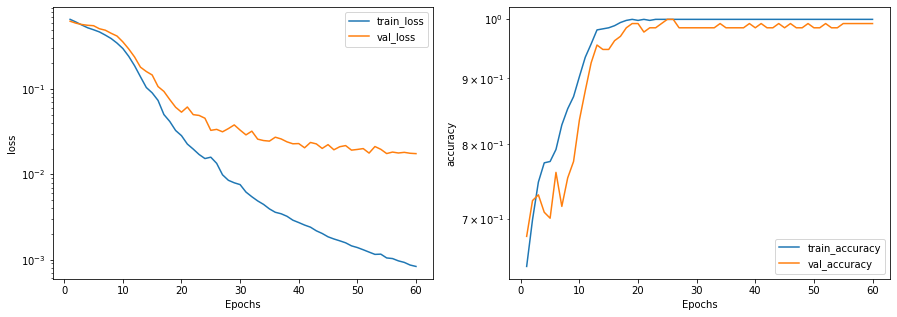

In [28]:
plot_metrics(history2,'loss','accuracy')

**Measuring the performance after applying a new layer**

In [29]:
y_pred_tr2 = np.argmax(model2.predict(X_train), axis=1).reshape(-1,1)
y_pred_te2 = np.argmax(model2.predict(X_test), axis=1).reshape(-1,1)

model_performance_class(y_train, y_pred_tr2, y_test, y_pred_te2)

9/9 [==============================] - 0s 3ms/step
Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       236
        True       1.00      1.00      1.00       434

    accuracy                           1.00       670
   macro avg       1.00      1.00      1.00       670
weighted avg       1.00      1.00      1.00       670

Results obtained for the TEST SET
The Cohen's Kappa is: 0.98
              precision    recall  f1-score   support

       False       0.99      0.99      0.99        96
        True       0.99      0.99      0.99       192

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



### Using optimizers

**Creating a new the model with optimizers and decreasing the learning rate**

In [30]:
model3 = keras.Sequential()
#hidden layers
model3.add(Dense(units = 64,input_dim = X_train.shape[1],activation='relu'))
model3.add(Dense(units = 16,activation='relu'))
model3.add(Dense(units = 8,activation='relu'))
#final layer
model3.add(Dense(units = 2, activation='softmax'))

special_Adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True)

model3.compile(optimizer=special_Adam,
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

**Fitting the model**

In [31]:
history3 = model3.fit(X_train, y_train, epochs=60, validation_split=0.20, batch_size=20, callbacks=[early_stopping, checkpoint])

Epoch 1/60
16/27 [================>.............] - ETA: 0s - loss: 0.7427 - accuracy: 0.3938 
Epoch 1: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 2s 43ms/step - loss: 0.7320 - accuracy: 0.3899 - val_loss: 0.6980 - val_accuracy: 0.4776
Epoch 2/60
24/27 [=========================>....] - ETA: 0s - loss: 0.6754 - accuracy: 0.6313
Epoch 2: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 0s 6ms/step - loss: 0.6729 - accuracy: 0.6343 - val_loss: 0.6604 - val_accuracy: 0.6642
Epoch 3/60
23/27 [========================>.....] - ETA: 0s - loss: 0.6405 - accuracy: 0.7413
Epoch 3: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 0s 6ms/step - loss: 0.6392 - accuracy: 0.7332 - val_loss: 0.6276 - val_accuracy: 0.6716
Epoch 4/60
20/27 [=====================>....

**Plotting the metrics through epochs**

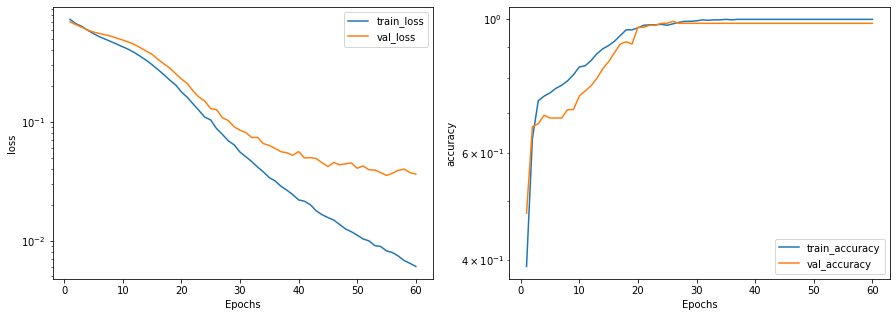

In [32]:
plot_metrics(history3,'loss','accuracy')

**Measuring the performance after decreasing the learning rate**

In [33]:
y_pred_tr3 = np.argmax(model3.predict(X_train), axis=1).reshape(-1,1)
y_pred_te3 = np.argmax(model3.predict(X_test), axis=1).reshape(-1,1)

model_performance_class(y_train, y_pred_tr3, y_test, y_pred_te3)

9/9 [==============================] - 0s 3ms/step
Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.99
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       236
        True       1.00      1.00      1.00       434

    accuracy                           1.00       670
   macro avg       1.00      1.00      1.00       670
weighted avg       1.00      1.00      1.00       670

Results obtained for the TEST SET
The Cohen's Kappa is: 0.97
              precision    recall  f1-score   support

       False       0.96      1.00      0.98        96
        True       1.00      0.98      0.99       192

    accuracy                           0.99       288
   macro avg       0.98      0.99      0.98       288
weighted avg       0.99      0.99      0.99       288



### Increasing the epochs

**Creating the new model**

In [34]:
model4 = keras.Sequential()
#hidden layers
model4.add(Dense(units = 64,input_dim = X_train.shape[1],activation='relu'))
model4.add(Dense(units = 16,activation='relu'))
model4.add(Dense(units = 8,activation='relu'))
#final layer
model4.add(Dense(units = 2, activation='softmax'))

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

**Fitting the model**

In [35]:
history4 = model4.fit(X_train, y_train, epochs=500, validation_split=0.20, batch_size=20, callbacks=[early_stopping,checkpoint])

Epoch 1/500
22/27 [=======================>......] - ETA: 0s - loss: 0.6447 - accuracy: 0.6318  
Epoch 1: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 4s 22ms/step - loss: 0.6368 - accuracy: 0.6418 - val_loss: 0.6058 - val_accuracy: 0.7015
Epoch 2/500
22/27 [=======================>......] - ETA: 0s - loss: 0.5787 - accuracy: 0.7023
Epoch 2: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 1s 21ms/step - loss: 0.5751 - accuracy: 0.7108 - val_loss: 0.5718 - val_accuracy: 0.7015
Epoch 3/500
16/27 [================>.............] - ETA: 0s - loss: 0.5283 - accuracy: 0.7594
Epoch 3: saving model to /content/drive/MyDrive/Ironhack/Bootcamp/Deep_Learning_Lab/model.hdf5
27/27 [==============================] - 0s 7ms/step - loss: 0.5297 - accuracy: 0.7556 - val_loss: 0.5542 - val_accuracy: 0.6866
Epoch 4/500
24/27 [====================

**Plotting the metrics through epochs**

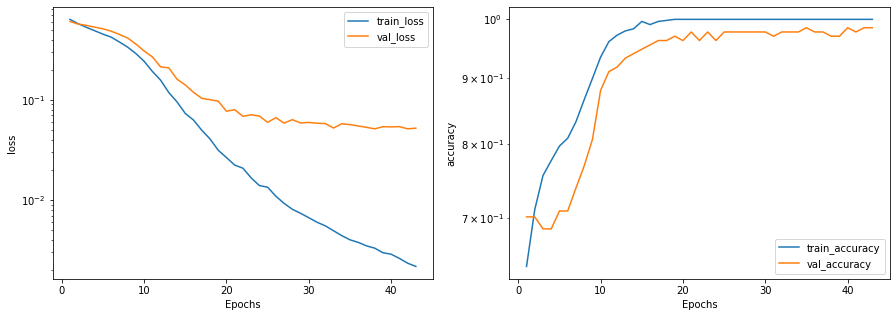

In [36]:
plot_metrics(history4,'loss','accuracy')

**Measuring the performance after increasing the epochs**

In [37]:
y_pred_tr4 = np.argmax(model4.predict(X_train), axis=1).reshape(-1,1)
y_pred_te4 = np.argmax(model4.predict(X_test), axis=1).reshape(-1,1)

model_performance_class(y_train, y_pred_tr4, y_test, y_pred_te4)

9/9 [==============================] - 0s 3ms/step
Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.99
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       236
        True       1.00      1.00      1.00       434

    accuracy                           1.00       670
   macro avg       1.00      1.00      1.00       670
weighted avg       1.00      1.00      1.00       670

Results obtained for the TEST SET
The Cohen's Kappa is: 0.95
              precision    recall  f1-score   support

       False       0.94      0.99      0.96        96
        True       0.99      0.97      0.98       192

    accuracy                           0.98       288
   macro avg       0.97      0.98      0.97       288
weighted avg       0.98      0.98      0.98       288



**Which approach(es) did you find helpful to improve your model performance?**

Adding a new layer gave us the best result but the other approaches also improved the original model but decrased the performance after applying the new layer, but the model was already quite good form the beggining.